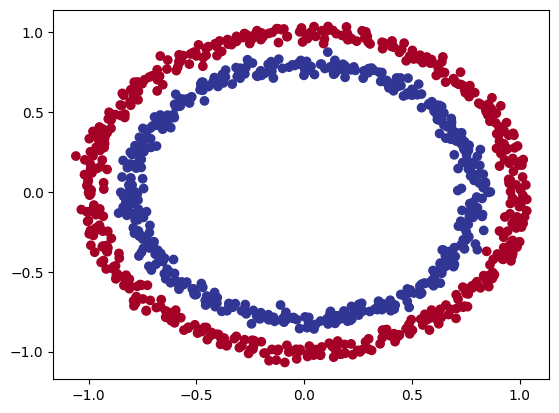

In [94]:
# 6. The missing piece: non-linearity
# 비선형 데이터 만들기 , 모델 구축하기 ReLu, 모델 훈련, 결과 평가 decision boundary로 시각적 확인 

# Make and plot data 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples,
                   noise = 0.03, 
                   random_state= 42)

plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [95]:
# Convert data to tensors and then to train and test splits 
import torch 
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) 
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42) 

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [96]:
# Build a model with non-linear activation functions
from torch import nn
# Import PyTorch and nn
import torch
from torch import nn  # nn 모듈을 임포트해야 nn.Module, nn.Linear 등을 사용할 수 있습니다.

# 기기 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function
    
  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [97]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [98]:
# Training a model with non linearlity 
len(X_test), len(y_test)

(200, 200)

In [99]:
# Random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put all data on target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data 
epochs = 1000

# Define accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100  # 퍼센트로 정확도 계산
    return acc

for epoch in range(epochs):
    ### Training 
    model_3.train()

    # 1. forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # 시그모이드를 거쳐 예측 확률을 이진 레이블로 변환

    # 2. Calculate the training loss and accuracy
    loss = loss_fn(y_logits, y_train)  # 손실 함수 계산
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)  # 정확도 계산
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()  # 기울기 초기화

    # 4. Loss backward 
    loss.backward()  # 역전파를 통해 기울기 계산

    # 5. step the optimizer 
    optimizer.step()  # 옵티마이저가 파라미터 업데이트

    ### Testing 
    model_3.eval()
    with torch.inference_mode():  # 테스트 시에는 기울기 계산을 하지 않음
        test_logits = model_3(X_test).squeeze()  # 테스트 데이터로 예측 수행
        test_pred = torch.round(torch.sigmoid(test_logits))  # 예측 확률을 이진 레이블로 변환

        # 6. Calculate the test loss and accuracy (빠진 부분 추가)
        test_loss = loss_fn(test_logits, y_test)  # 테스트 데이터에 대한 손실 계산
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)  # 테스트 데이터에 대한 정확도 계산

    # Print out the status every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.6927, Acc: 49.25% | Test Loss: 0.6922, Test Acc: 48.50%
Epoch: 100 | Loss: 0.6904, Acc: 52.38% | Test Loss: 0.6900, Test Acc: 51.50%
Epoch: 200 | Loss: 0.6887, Acc: 50.62% | Test Loss: 0.6881, Test Acc: 55.50%
Epoch: 300 | Loss: 0.6867, Acc: 52.25% | Test Loss: 0.6859, Test Acc: 54.50%
Epoch: 400 | Loss: 0.6841, Acc: 61.12% | Test Loss: 0.6833, Test Acc: 64.50%
Epoch: 500 | Loss: 0.6808, Acc: 59.88% | Test Loss: 0.6798, Test Acc: 67.00%
Epoch: 600 | Loss: 0.6763, Acc: 58.13% | Test Loss: 0.6754, Test Acc: 61.00%
Epoch: 700 | Loss: 0.6705, Acc: 58.13% | Test Loss: 0.6697, Test Acc: 62.50%
Epoch: 800 | Loss: 0.6629, Acc: 58.50% | Test Loss: 0.6626, Test Acc: 62.00%
Epoch: 900 | Loss: 0.6525, Acc: 59.38% | Test Loss: 0.6535, Test Acc: 61.50%


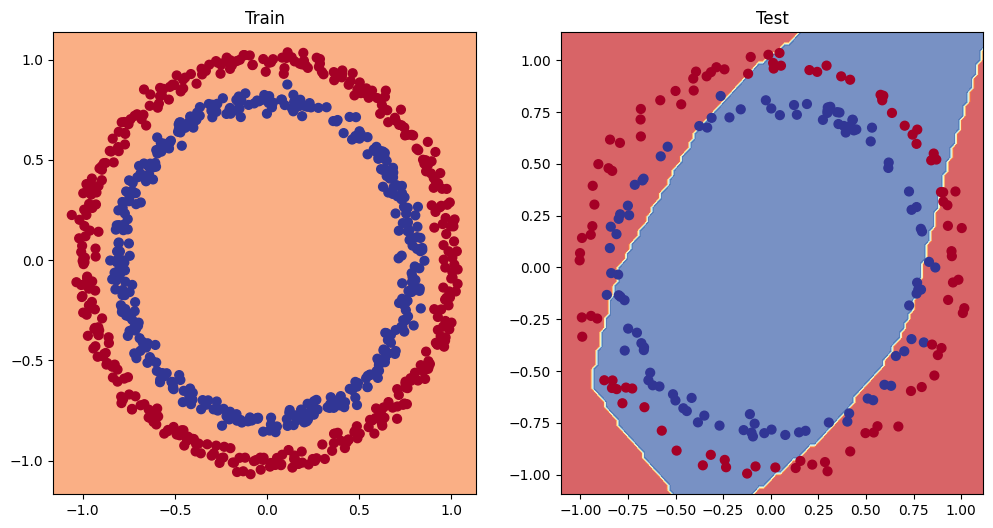

In [100]:
from helper_functions import plot_decision_boundary  # helper_functions에서 가져와야 함

# Create a linear model (model_1) using nn.Sequential
# 이 모델은 non-linearity가 없는 순차적인 선형 모델입니다.
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),  # 첫 번째 레이어: 2개의 입력을 5개의 출력으로 변환
    nn.Linear(in_features=5, out_features=1)   # 두 번째 레이어: 5개의 입력을 1개의 출력으로 변환 (결과값)
).to(device)

# 모델을 생성한 후 'device'로 기기에 할당
model_1.to(device)

# 이 모델은 이전에 classification 모델로 사용된 것일 가능성이 높습니다.

# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity